## import data and libraries

In [96]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU device: NVIDIA GeForce RTX 3050 Ti Laptop GPU
GPU memory: 4.3 GB


In [97]:
class ModelNetCustomDataset(Dataset):
    def __init__(self, train: bool, classes=None, debug=True):
        self.debug = debug
        
        if train:
            x = torch.load("../data/ModelNet_subset/train_x.pt", weights_only=True)
            y = torch.load("../data/ModelNet_subset/train_y.pt", weights_only=True)
        else:
            x = torch.load("../data/ModelNet_subset/test_x.pt", weights_only=True)
            y = torch.load("../data/ModelNet_subset/test_y.pt", weights_only=True)

        # Load class names
        raw_dir = r"C:\Users\snevi\OneDrive\Documents\coding\AI\deep_learning\data\ModelNet\raw"
        self.class_names = sorted([
            name for name in os.listdir(raw_dir)
            if os.path.isdir(os.path.join(raw_dir, name))
        ])

        # Initialize mappings
        self.class_mapping = None
        self.reverse_mapping = None
        self.original_classes = classes

        if self.debug:
            print(f"Original data shapes: x={x.shape}, y={y.shape}")
            print(f"Original label range: [{y.min()}, {y.max()}]")
            print(f"Classes to filter: {classes}")

        # Filter classes FIRST, then standardize the filtered data
        if classes is not None:
            x, y = self.filter_classes(x, y, classes)
            
            if self.debug:
                print(f"After filtering: x={x.shape}, y={y.shape}")
                print(f"Filtered label range: [{y.min()}, {y.max()}]")

            # Create mapping from original class IDs to new contiguous IDs
            self.class_mapping = {original_id: new_id for new_id, original_id in enumerate(sorted(classes))}
            self.reverse_mapping = {new_id: original_id for original_id, new_id in self.class_mapping.items()}
            
            if self.debug:
                print(f"Class mapping: {self.class_mapping}")
            
            # Remap class IDs to be contiguous [0, 1, 2, ..., len(classes)-1]
            y = self.remap_classes(y)
            
            if self.debug:
                print(f"After remapping: label range [{y.min()}, {y.max()}]")
                print(f"Expected range: [0, {len(classes)-1}]")

        # Apply standardization to the (potentially filtered) data
        self.x = self.standardise(x)
        self.y = y
        
        if self.debug:
            print(f"Final dataset: x={self.x.shape}, y={self.y.shape}")
            print(f"Final label range: [{self.y.min()}, {self.y.max()}]")
        
    def remap_classes(self, y):
        """Remap original class IDs to contiguous range [0, 1, 2, ...]"""
        y_remapped = torch.zeros_like(y)
        for i in range(len(y)):
            original_class = y[i].item()
            if original_class not in self.class_mapping:
                raise ValueError(f"Class {original_class} not found in mapping {self.class_mapping}")
            new_class = self.class_mapping[original_class]
            y_remapped[i] = new_class
        return y_remapped

    def standardise(self, x):
        standardised_data = torch.zeros_like(x)
        for i in range(x.shape[0]):
            obj = x[i]
            mean_x = obj.mean(dim=0)
            std_x = obj.std()
            standardised_data[i] = (obj - mean_x) / (std_x + 1e-8)
        return standardised_data

    def filter_classes(self, x, y, classes):
        indices_to_keep = []
        for idx in range(len(y)):
            if y[idx].item() in classes:
                indices_to_keep.append(idx)
        
        if len(indices_to_keep) == 0:
            raise ValueError(f"No samples found for classes {classes}")
        
        x_selected = torch.index_select(x, dim=0, index=torch.tensor(indices_to_keep))
        y_selected = torch.index_select(y, dim=0, index=torch.tensor(indices_to_keep))
        return x_selected, y_selected

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        point_cloud = self.x[idx]
        class_id = self.y[idx]

        # Get original class name using reverse mapping
        if self.reverse_mapping is not None:
            original_class_id = self.reverse_mapping[class_id.item()]
            label = self.class_names[original_class_id]
        else:
            label = self.class_names[class_id.item()]
        
        return point_cloud, class_id, label

## steps

In [98]:
def accuracy_fn(y_pred,y_true):
    """
    Calculate accuracy of predictions
    Args:
        y_pred: Predictions from model (logits)
        y_true: True labels
    Returns:
        Accuracy as a percentage
    """
    # Get predicted class indices by taking argmax along the last dimension
    y_pred_indices = torch.argmax(y_pred, dim=1)
    
    # Compare with true labels and calculate accuracy
    correct = (y_pred_indices == y_true).sum().item()
    total = y_true.size(0)
    
    return correct / total * 100  # Return accuracy as percentage

In [ ]:
def train_step(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn: nn.Module,
        optimiser: torch.optim.Optimizer,
        accuracy_fn,
        device: torch.device = device,
        verbose: bool=True):

    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    
    #print(f"training loop on {device}...")
    
    for batch, (X, y, names) in enumerate(data_loader):
        
        try:
            # Move data to device
            X, y = X.to(device), y.to(device)
            
            # Fix label shape
            if y.dim() > 1:
                y = y.squeeze()
            y=y.long()

            # Forward pass
            y_pred = model(X)
            
            # Loss and accuracy
            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_pred, y)
            
            train_loss += loss.item()
            train_acc += acc
            
            # Backward
            optimiser.zero_grad()
            loss.backward()
            
            # Update
            optimiser.step()

            # if batch % 400 == 0:
            #     print(f"TRAIN: Processed {batch * len(X)}/{len(data_loader.dataset)} samples")
            
        except Exception as e:
            print(f"   Error in batch {batch + 1}: {e}")
            import traceback
            traceback.print_exc()
            break
    
    # Calculate averages
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    if verbose == True:
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc


In [ ]:
def test_step(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn: nn.Module,
        accuracy_fn,
        device: torch.device = device,
        verbose: bool=True
):
        test_loss, test_acc = 0, 0
        model.to(device)
        model.eval()  # Set model to evaluation mode
        with torch.inference_mode():  # No gradients needed for inference
            try:
                for batch, (X, y, names) in enumerate(data_loader):
                    X, y = X.to(device), y.to(device)

                    if y.dim() > 1:
                        y = y.squeeze()  # Converts [64, 1] to [64]
                    y=y.long()
                    
                    y_pred = model(X)

                    loss = loss_fn(y_pred, y)
                    acc = accuracy_fn(y_pred, y)

                    test_loss += loss.item()
                    test_acc += acc

                    # if batch % 400 == 0:
                    #     print(f"Processed {batch * len(X)}/{len(data_loader.dataset)} samples")
            except Exception as e:
                print(f"   Error in batch {batch + 1}: {e}")
                import traceback
                traceback.print_exc()

            # Average loss per batch per epoch
            test_loss /= len(data_loader)
            test_acc /= len(data_loader)
            if verbose == True:
                print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
        return test_loss, test_acc

In [ ]:
def train_model(model,epochs, verbose = True):
    train_accs,test_accs,train_losses,test_losses=[],[],[],[]
    loss_fn= nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Added weight decay for regularisation

    # Use tqdm only if verbose is True
    epoch_iterator = tqdm(range(epochs)) if verbose else range(epochs)
    
    for epoch in epoch_iterator:
        if verbose:
            print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train step
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimiser=optimiser,
            accuracy_fn=accuracy_fn,
            device=device
        )
        
        # Test step
        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device
        )
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    if not verbose:
        print(f"Final: Train Acc: {train_accs[-1]:.2f}%, Test Acc: {test_accs[-1]:.2f}%")
    
    
    return train_accs, test_accs, train_losses, test_losses


In [102]:
def plot_acc_losses(
        model_name: str,
        train_accs: list,
        test_accs: list,
        train_losses: list,
        test_losses: list,
        epochs: int = 7
):
        f,(ax1,ax2)=plt.subplots(1,2)
        f.set_size_inches(15,5)
        ax1.plot(np.arange(1,epochs+1,1),test_accs,label="Test Accuracies")
        ax1.plot(np.arange(1,epochs+1,1),train_accs, label="Train Accuracies")
        ax1.set_title(f"{model_name} Accuracies")
        ax1.legend()
        ax1.set_ylabel("Accuracies (%)")
        ax1.set_xlabel("Epochs")

        ax2.plot(np.arange(1,epochs+1,1),test_losses, label="Test Losses")
        ax2.plot(np.arange(1,epochs+1,1),train_losses, label="Train Losses")
        ax2.set_title(f"{model_name} Losses")
        ax2.legend()
        ax2.set_ylabel("Losses")
        ax2.set_xlabel("Epochs")
    

## models

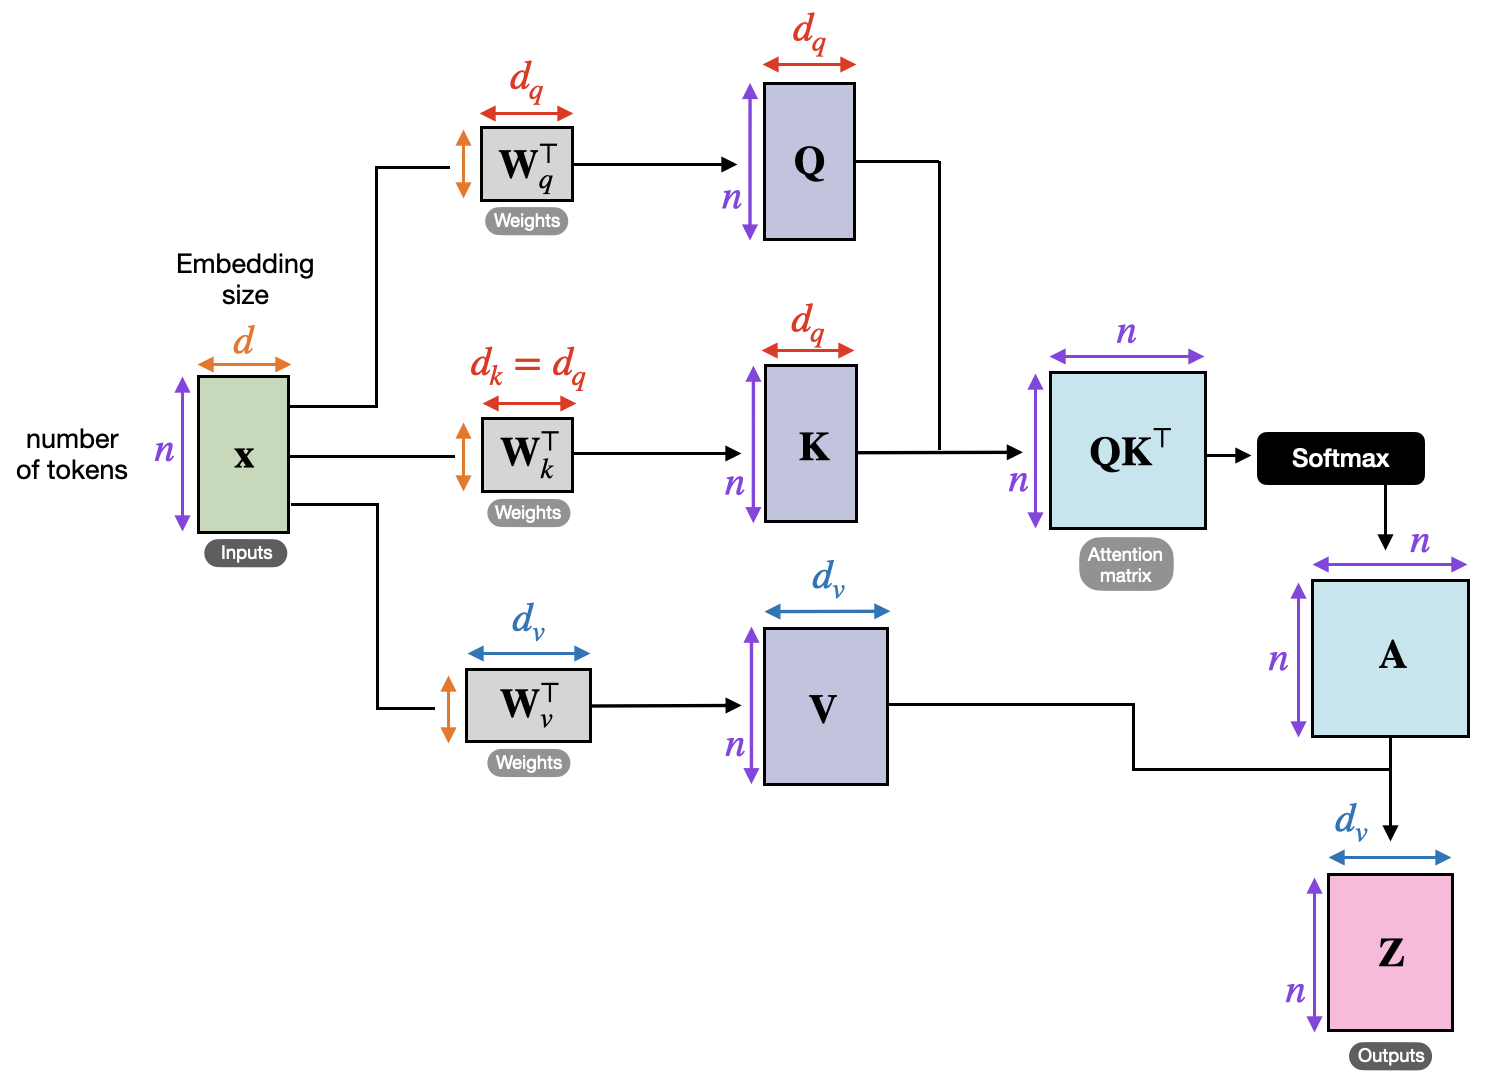

let $d_k = d_q = d_v = D$ to allow layers to stack

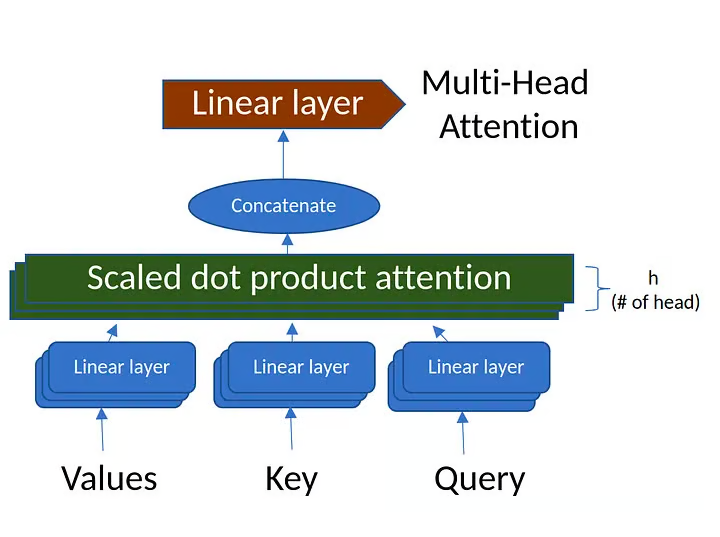

Instead of one head, use h heads with smaller per-head width $d_h=d_{model}/h$. Each head learns different relational subspaces as each head has its own $W_Q, ~ W_K, ~ W_V$ - can capture diverse patterns eg local vs global. Typically choose, $d_{model}=h~x~d_h, ~ d_k=d_v=d_h$. 
Concatenate head outputs and project back to $d_{model}$.

In [103]:
class MultiHeadAttention(nn.Module):
    """
    x: (B, N, D)
        N = num of features
        D = dim of model
    Returns: (B, N, D) where D = out_dim
    """
    def __init__(self,
            dim:int,
            num_heads:int,
            #p_drop: float = 0.0
        ):
        super().__init__()

        self.dim=dim #dim of input
        self.num_heads=num_heads
        
        self.d_k=dim//num_heads #D//h = Dimension of each head's key, query, and value

        self.W_q=nn.Linear(dim,dim) 
        self.W_k=nn.Linear(dim,dim)
        self.W_v=nn.Linear(dim,dim)

        self.W_y=nn.Linear(dim,dim) #output transformation

        # #dropout for attention probabilities - randomly zeroes fraction p and rescales rest by 1/(1-p) (Pytorch inverted dropout)
        # #encourages model not to rely on single sharp attention pattern to improve generalisation
        # self.attn_drop = nn.Dropout(p_drop)

        # #feature dropout on per-token features produced by attention - randomly zeros elements of output vectors
        # self.proj_drop = nn.Dropout(p_drop)

    def split_heads(self,x):
        batch,n,dim=x.size()
        x_split=x.reshape(batch,n,self.num_heads,self.d_k).transpose(-3,-2)
        #print('x ',x.shape)
        #print('x spl', x_split.shape)
        return x_split

    def combine_heads(self,x_split):
        batch,num_heads,n,d_k=x_split.size()
        # x_final = x_split.reshape(batch,n,self.dim).transpose(-2,-1)
        x_final = x_split.reshape(batch,n,self.dim)
        # print(f"x1 shape {x1.shape}")
        # x_final = x1.transpose(-2,-1)
        #print(f"x_final shape {x_final.shape}")
        return x_final

    def scaled_dot_product_attention(self,q_split,k_split,v_split):
        #calculate attention weights
        # k.T flips all dims, including batch -> only need to transpose last two dims
        # k:(B,N,D) -> k.T:(D,N,B)
        # (B,N,D) @ (B,D,N) -> (B,N,N)

        # #single head:
        # scores = (q @ k.transpose(-2, -1)) * self.scale  # (B, N, N)
        # attn = torch.softmax(scores, dim=-1)             # (B, N, N)
        # attn = self.attn_drop(attn)
        # y = attn @ v                                     # (B, N, D)
        # y = self.proj_drop(y)

        k_split_T = k_split.transpose(-2,-1)
        #print('k spl t ',k_split_T.shape)
        #print('q spl ', q_split.shape)  

        attn_scores = torch.matmul(q_split,k_split_T) / math.sqrt(self.d_k)
        attn_probs = torch.softmax(attn_scores,dim=-1)
        y_split = torch.matmul(attn_probs,v_split)
        #print(f"y_split shape {y_split.shape}")

        return y_split

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, N, E)
        q_split = self.split_heads(self.W_q(x))                     # (B, N, D) -> (B, h, N, D/h)
        k_split = self.split_heads(self.W_k(x))                     # (B, N, D) -> (B, h, N, D/h)
        v_split = self.split_heads(self.W_v(x))                     # (B, N, D) -> (B, h, N, D/h)

        y_split=self.scaled_dot_product_attention(q_split,k_split,v_split)
        y=self.W_y(self.combine_heads(y_split))

        return y

In [104]:
class MultiHeadClassifier(nn.Module):
    """
    attention classifier for point clouds.
    Input: (B, N, 3)

    -- attn(d_k,d_v,out_dim) --> (B,N,D)
    -- mean pooling --> (B,D)
    -- linear --> (B, num_classes)

    Output: (B, num_classes) logits
    """
    def __init__(self, 
            num_classes:int,
            embed_dim:int =64,
            num_heads:int=8,
            p_drop: float = 0.1):
        
        super().__init__()

        #takes each point's raw coords (x,y,z) and lifts them into richer feature space of size embed_dim
        #3 numbers too limited for attention to learn useful relations
        #small MLP creates more expressive per-point features


        self.embed=nn.Sequential(
            nn.Linear(3,embed_dim),
            nn.ReLU()
        )

        self.attn = MultiHeadAttention(
            dim=embed_dim,
            num_heads=num_heads
        #,p_drop=p_drop
        )

        #if ever switch back to mean-only, change the head to nn.Linear(out_dim, num_classes)
        self.head = nn.Linear(embed_dim, num_classes) 

    def forward(self, x):
        x=self.embed(x)         # (B, N, embed_dim)
        x=self.attn(x)            # (B, N, out_dim)

        #mean pool over points, averages over N points
        #symmetric reduction - permutation-invariant as reordering points does not change mean - important as point cloud is an unordered set
        #smooth, noise tolerant summary
        feat_mean = x.mean(dim=1)        # (B, D) 

        #max pool over points, takes max over N points
        #takes strongest activation per channel to pick out edge like features
        # feat_max = x.amax(dim=1)   # (B, out_dim)

        #global pooling - fuses smooth global trends and extremes -> gives small accuracy boost
        #feat = torch.cat([feat_mean,feat_max],dim=-1) # (B, 2*out_dim)

        #pooled feature goes through linear layer to produce class logits suitable for nn.CrossEntropyLoss
        logits = self.head(feat_mean)    # (B, num_classes)
        return logits


## test

In [105]:
#selected_classes = [0, 5, 6, 7, 8, 10, 19, 24, 26, 30, 32, 33, 34, 35, 37]
all_classes = [i for i in range(0,40)]
poor_classes = [24,39,1,21,36,12,23,3,10,15,11,38,29,13,27]
selected_classes = [i for i in all_classes if i not in poor_classes]
NUM_CLASSES = len(selected_classes)
train_dataset = ModelNetCustomDataset(train=True, classes=selected_classes, debug=False)
test_dataset = ModelNetCustomDataset(train=False, classes=selected_classes, debug=False)

BATCH_SIZE = 32
EPOCHS = 20
INPUT_SHAPE = (200, 3)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [106]:
# attention_model = MultiHeadClassifier(
#     num_classes=NUM_CLASSES, embed_dim=128, num_heads=4,
#     p_drop=0.1
# ).to(device)

In [107]:
# (train_accs, test_accs,
#  train_losses, test_losses) = train_model(attention_model, epochs=EPOCHS)

In [108]:
# plot_acc_losses(
#     model_name="Multi Head Attention Classifier",
#     train_accs=train_accs,
#     test_accs=test_accs,
#     train_losses=train_losses,
#     test_losses=test_losses,
#     epochs=EPOCHS
# )

In [109]:
import pandas as pd
import itertools
import time
import os
from datetime import timedelta
import copy
import seaborn as sns

In [ ]:
def grid_search_attention_model(
    train_dataloader, 
    test_dataloader, 
    num_classes,
    device,
    embed_dims=[64, 128, 256, 512],
    num_heads_list=[4, 8, 16],
    p_drops=[0.0, 0.1, 0.2],
    epochs_list=[20],
    save_best=True,
    results_dir="grid_search_results"
):
    """
    Perform grid search for MultiHeadClassifier with pandas DataFrame tracking.
    Results are sorted by test accuracy.
    """
    
    print("Starting grid search for MultiHeadClassifier...")
    
    # Create directory for results if it doesn't exist
    if save_best and not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    # Generate all parameter combinations
    param_combinations = list(itertools.product(embed_dims, num_heads_list, p_drops, epochs_list))
    
    # Filter out invalid combinations (embed_dim must be divisible by num_heads)
    valid_combinations = [(ed, nh, pd, ep) for ed, nh, pd, ep in param_combinations if ed % nh == 0]
    
    print(f"Total valid parameter combinations: {len(valid_combinations)}")
    
    # Initialize results DataFrame
    results_df = pd.DataFrame(columns=[
        'embed_dim', 'num_heads', 'p_drop', 'epochs',
        'train_acc', 'test_acc', 'train_loss', 'test_loss', 
        'time_seconds', 'model_name'
    ])
    
    best_test_acc = 0
    best_model = None
    
    # Loop through combinations
    for i, (embed_dim, num_heads, p_drop, epochs) in enumerate(tqdm(valid_combinations, desc="Grid Search Progress")):
        # Create model name
        model_name = f"E{embed_dim}_H{num_heads}_D{p_drop}_Ep{epochs}"
        
        print(f"\n[{i+1}/{len(valid_combinations)}] Testing: {model_name}")
        
        # Initialize model
        model = MultiHeadClassifier(
            num_classes=num_classes,
            embed_dim=embed_dim,
            num_heads=num_heads,
            p_drop=p_drop
        ).to(device)
        
        # Train and time the model
        start_time = time.time()
        train_accs, test_accs, train_losses, test_losses = train_model(model, epochs,verbose=False)
        training_time = time.time() - start_time
        
        # Get final metrics
        final_train_acc = train_accs[-1]
        final_test_acc = test_accs[-1]
        final_train_loss = train_losses[-1]
        final_test_loss = test_losses[-1]
        
        # Add results to DataFrame
        new_row = pd.DataFrame([{
            'embed_dim': embed_dim,
            'num_heads': num_heads,
            'p_drop': p_drop,
            'epochs': epochs,
            'train_acc': final_train_acc,
            'test_acc': final_test_acc,
            'train_loss': final_train_loss,
            'test_loss': final_test_loss,
            'time_seconds': training_time,
            'model_name': model_name
        }])
        
        results_df = pd.concat([results_df, new_row], ignore_index=True)
        
        # Save intermediate results
        if save_best:
            results_df.to_csv(f"{results_dir}/grid_search_results.csv", index=False)
        
        # Check if this is the best model
        if final_test_acc > best_test_acc:
            best_test_acc = final_test_acc
            best_model = copy.deepcopy(model)
            
            # Save best model
            if save_best:
                torch.save(model.state_dict(), f"{results_dir}/best_model.pt")
                
        # Print summary
        print(f"Results: Train Acc: {final_train_acc:.2f}%, Test Acc: {final_test_acc:.2f}%")
        print(f"Time: {timedelta(seconds=int(training_time))}")
        
        # Sort and save updated results
        results_df = results_df.sort_values(by='test_acc', ascending=False).reset_index(drop=True)
        if save_best:
            results_df.to_csv(f"{results_dir}/grid_search_results_sorted.csv", index=False)
    
    # Final summary
    print("\n" + "="*50)
    print("Grid Search Complete!")
    print("="*50)
    
    # Display top 5 models
    print("\nTop 5 Models by Test Accuracy:")
    display(results_df.head(5))
    
    # Visualize results
    plot_grid_search_results(results_df)
    
    return results_df, best_model

def plot_grid_search_results(results_df):
    """Plot grid search results from DataFrame"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(15, 10))
    
    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Embed Dim vs Test Accuracy
    sns.barplot(x='embed_dim', y='test_acc', data=results_df, ax=axs[0, 0], 
                order=sorted(results_df['embed_dim'].unique()))
    axs[0, 0].set_title('Embedding Dimension vs Test Accuracy')
    axs[0, 0].set_xlabel('Embedding Dimension')
    axs[0, 0].set_ylabel('Test Accuracy (%)')
    
    # Plot 2: Num Heads vs Test Accuracy
    sns.barplot(x='num_heads', y='test_acc', data=results_df, ax=axs[0, 1],
                order=sorted(results_df['num_heads'].unique()))
    axs[0, 1].set_title('Number of Attention Heads vs Test Accuracy')
    axs[0, 1].set_xlabel('Number of Attention Heads')
    axs[0, 1].set_ylabel('Test Accuracy (%)')
    
    # Plot 3: Dropout vs Test Accuracy
    sns.barplot(x='p_drop', y='test_acc', data=results_df, ax=axs[1, 0],
                order=sorted(results_df['p_drop'].unique()))
    axs[1, 0].set_title('Dropout Rate vs Test Accuracy')
    axs[1, 0].set_xlabel('Dropout Rate')
    axs[1, 0].set_ylabel('Test Accuracy (%)')
    
    # Plot 4: Top 5 Models
    top5 = results_df.head(5)
    sns.barplot(x='model_name', y='test_acc', data=top5, ax=axs[1, 1])
    axs[1, 1].set_title('Top 5 Models by Test Accuracy')
    axs[1, 1].set_xlabel('Model Configuration')
    axs[1, 1].set_ylabel('Test Accuracy (%)')
    axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('grid_search_results.png', dpi=300, bbox_inches='tight')
    plt.show()

embed_dims=[128, 256, 512]
num_heads_list=[4, 8, 16]
p_drops=[0.0, 0.1, 0.2]
epochs_list=[20]
# embed_dims = [128]
# num_heads_list = [2, 4]
# p_drops = [0.1]
# epochs_list = [5]

# Run grid search
results_df, best_model = grid_search_attention_model(
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    num_classes=NUM_CLASSES,
    device=device,
    embed_dims=embed_dims,
    num_heads_list=num_heads_list,
    p_drops=p_drops,
    epochs_list=epochs_list
)

# # Train best model for more epochs if desired
# print("\nTraining best model for more epochs...")
best_config = results_df.iloc[0]

final_model = MultiHeadClassifier(
    num_classes=NUM_CLASSES,
    embed_dim=int(best_config['embed_dim']),
    num_heads=int(best_config['num_heads']),
    p_drop=float(best_config['p_drop'])
).to(device)

train_accs, test_accs, train_losses, test_losses = train_model(final_model, epochs=best_config['epochs'])

# Plot results
plot_acc_losses(
    model_name=f"Best Model: {best_config['model_name']}",
    train_accs=train_accs,
    test_accs=test_accs,
    train_losses=train_losses,
    test_losses=test_losses,
    epochs=best_config['epochs']
)

Starting grid search for MultiHeadClassifier...
Total valid parameter combinations: 27


Grid Search Progress:   0%|          | 0/27 [00:00<?, ?it/s]


[1/27] Testing: E128_H4_D0.0_Ep20



Epoch 1/20


Train loss: 2.01771 | Train accuracy: 41.31%
Test loss: 1.76783 | Test accuracy: 41.96%

Epoch 2/20


Train loss: 1.24332 | Train accuracy: 63.85%
Test loss: 1.29555 | Test accuracy: 60.34%

Epoch 3/20


Train loss: 1.05376 | Train accuracy: 69.71%
Test loss: 1.12049 | Test accuracy: 66.44%

Epoch 4/20


Train loss: 0.94919 | Train accuracy: 72.73%
Test loss: 0.99481 | Test accuracy: 70.63%

Epoch 5/20


Train loss: 0.86545 | Train accuracy: 75.04%
Test loss: 0.94854 | Test accuracy: 72.55%

Epoch 6/20


Train loss: 0.80236 | Train accuracy: 76.82%
Test loss: 0.87003 | Test accuracy: 75.21%

Epoch 7/20


Train loss: 0.76900 | Train accuracy: 77.82%
Test loss: 0.88887 | Test accuracy: 74.14%

Epoch 8/20


Train loss: 0.74061 | Train accuracy: 78.12%
Test loss: 0.85946 | Test accuracy: 75.03%

Epoch 9/20


Train loss: 0.69638 | Train accuracy: 80.25%
Test loss: 0.78924 | Test accuracy: 78.80%

Epoch 10/20


Train loss: 0.68935 | Train accuracy: 80.00%
Test loss: 0.80647 | Test accuracy: 78.35%

Epoch 11/20


Train loss: 0.65762 | Train accuracy: 81.69%
Test loss: 0.80699 | Test accuracy: 78.18%

Epoch 12/20


Train loss: 0.65152 | Train accuracy: 81.15%
Test loss: 0.79420 | Test accuracy: 78.14%

Epoch 13/20


Train loss: 0.63247 | Train accuracy: 81.76%
Test loss: 0.79722 | Test accuracy: 77.63%

Epoch 14/20


Train loss: 0.62316 | Train accuracy: 81.62%
Test loss: 0.75963 | Test accuracy: 79.25%

Epoch 15/20
Train loss: 0.61777 | Train accuracy: 82.37%
Test loss: 0.72410 | Test accuracy: 79.98%



Epoch 16/20
Train loss: 0.59703 | Train accuracy: 82.33%
Test loss: 0.73340 | Test accuracy: 80.32%



Epoch 17/20
Train loss: 0.59328 | Train accuracy: 82.50%
Test loss: 0.80946 | Test accuracy: 77.98%



Epoch 18/20


Train loss: 0.58898 | Train accuracy: 82.57%
Test loss: 0.75108 | Test accuracy: 79.09%


 90%|█████████ | 18/20 [00:32<00:04,  2.15s/it]


Epoch 19/20
Train loss: 0.57037 | Train accuracy: 83.20%
Test loss: 0.75086 | Test accuracy: 79.22%



Epoch 20/20
Train loss: 0.55660 | Train accuracy: 83.88%
Test loss: 0.76686 | Test accuracy: 79.87%


100%|██████████| 20/20 [00:37<00:00,  1.87s/it]
C:\Users\snevi\AppData\Local\Temp\ipykernel_50412\1811322310.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
Grid Search Progress:   4%|▎         | 1/27 [00:37<16:11, 37.38s/it]

Results: Train Acc: 83.88%, Test Acc: 79.87%
Time: 0:00:37

[2/27] Testing: E128_H4_D0.1_Ep20



Epoch 1/20


Train loss: 1.94683 | Train accuracy: 42.06%
Test loss: 1.51290 | Test accuracy: 54.27%

Epoch 2/20


Train loss: 1.09592 | Train accuracy: 68.32%
Test loss: 1.14653 | Test accuracy: 64.60%

Epoch 3/20
Train loss: 0.93177 | Train accuracy: 73.34%


Test loss: 1.06562 | Test accuracy: 67.20%

Epoch 4/20
Train loss: 0.83943 | Train accuracy: 76.12%


Test loss: 0.99328 | Test accuracy: 70.92%

Epoch 5/20
Train loss: 0.80543 | Train accuracy: 77.14%


Test loss: 0.94857 | Test accuracy: 73.06%

Epoch 6/20
Train loss: 0.74607 | Train accuracy: 78.38%
Test loss: 0.85890 | Test accuracy: 75.58%



Epoch 7/20
Train loss: 0.71048 | Train accuracy: 79.27%


Test loss: 0.87047 | Test accuracy: 76.28%

Epoch 8/20
Train loss: 0.68360 | Train accuracy: 80.43%


Test loss: 0.90581 | Test accuracy: 74.83%

Epoch 9/20
Train loss: 0.67047 | Train accuracy: 80.53%


Test loss: 0.79114 | Test accuracy: 77.65%

Epoch 10/20
Train loss: 0.64874 | Train accuracy: 80.81%


Test loss: 0.80265 | Test accuracy: 78.32%

Epoch 11/20
Train loss: 0.65315 | Train accuracy: 81.47%


Test loss: 0.74518 | Test accuracy: 79.89%

Epoch 12/20
Train loss: 0.62046 | Train accuracy: 81.85%


Test loss: 0.74178 | Test accuracy: 79.92%

Epoch 13/20
Train loss: 0.62650 | Train accuracy: 81.96%


Test loss: 0.77427 | Test accuracy: 77.87%

Epoch 14/20
Train loss: 0.60212 | Train accuracy: 82.55%


Test loss: 0.74851 | Test accuracy: 79.17%

Epoch 15/20
Train loss: 0.58551 | Train accuracy: 83.11%
Test loss: 0.78844 | Test accuracy: 78.04%



Epoch 16/20
Train loss: 0.59440 | Train accuracy: 82.99%


Test loss: 0.78618 | Test accuracy: 78.26%

Epoch 17/20
Train loss: 0.57936 | Train accuracy: 83.10%


Test loss: 0.75682 | Test accuracy: 79.04%

Epoch 18/20
Train loss: 0.56193 | Train accuracy: 83.51%


Test loss: 0.71512 | Test accuracy: 80.97%

Epoch 19/20
Train loss: 0.55138 | Train accuracy: 83.83%


Test loss: 0.71301 | Test accuracy: 80.11%

Epoch 20/20


Grid Search Progress:   7%|▋         | 2/27 [01:43<22:30, 54.02s/it]

Train loss: 0.54419 | Train accuracy: 83.42%
Test loss: 0.69970 | Test accuracy: 80.16%
Results: Train Acc: 83.42%, Test Acc: 80.16%
Time: 0:01:05

[3/27] Testing: E128_H4_D0.2_Ep20



Epoch 1/20
Train loss: 1.99488 | Train accuracy: 42.07%


Test loss: 1.59946 | Test accuracy: 46.89%

Epoch 2/20
Train loss: 1.17094 | Train accuracy: 65.42%


Test loss: 1.16857 | Test accuracy: 66.13%

Epoch 3/20
Train loss: 0.96999 | Train accuracy: 72.41%


Test loss: 1.01851 | Test accuracy: 71.88%

Epoch 4/20
Train loss: 0.88129 | Train accuracy: 75.27%


Test loss: 0.97009 | Test accuracy: 72.81%

Epoch 5/20


Train loss: 0.82872 | Train accuracy: 76.87%
Test loss: 0.99892 | Test accuracy: 71.00%


 25%|██▌       | 5/20 [00:17<00:50,  3.34s/it]


Epoch 6/20
Train loss: 0.79101 | Train accuracy: 77.99%


Test loss: 0.90461 | Test accuracy: 74.73%

Epoch 7/20
Train loss: 0.76338 | Train accuracy: 78.55%
Test loss: 0.86544 | Test accuracy: 75.10%



Epoch 8/20
Train loss: 0.73475 | Train accuracy: 79.22%
Test loss: 0.87202 | Test accuracy: 75.56%



Epoch 9/20
Train loss: 0.71412 | Train accuracy: 79.99%


Test loss: 0.82271 | Test accuracy: 77.38%

Epoch 10/20
Train loss: 0.68788 | Train accuracy: 80.32%


Test loss: 0.92502 | Test accuracy: 74.39%

Epoch 11/20
Train loss: 0.68649 | Train accuracy: 80.16%


Test loss: 0.77639 | Test accuracy: 78.87%

Epoch 12/20
Train loss: 0.65669 | Train accuracy: 81.24%


Test loss: 0.74129 | Test accuracy: 78.77%

Epoch 13/20
Train loss: 0.63710 | Train accuracy: 81.58%


Test loss: 0.76641 | Test accuracy: 78.17%

Epoch 14/20


Train loss: 0.62331 | Train accuracy: 81.93%
Test loss: 0.73256 | Test accuracy: 79.38%

Epoch 15/20
Train loss: 0.61606 | Train accuracy: 82.07%


Test loss: 0.75083 | Test accuracy: 78.11%

Epoch 16/20



 80%|████████  | 16/20 [01:12<00:19,  4.79s/it]

Train loss: 0.59553 | Train accuracy: 82.74%
Test loss: 0.78382 | Test accuracy: 77.95%



Epoch 17/20
Train loss: 0.58988 | Train accuracy: 82.61%
Test loss: 0.68965 | Test accuracy: 80.13%



Epoch 18/20


Train loss: 0.59787 | Train accuracy: 82.70%
Test loss: 0.70125 | Test accuracy: 79.83%

Epoch 19/20


Train loss: 0.57612 | Train accuracy: 83.28%
Test loss: 0.71150 | Test accuracy: 79.76%

Epoch 20/20


Train loss: 0.56630 | Train accuracy: 83.47%
Test loss: 0.73419 | Test accuracy: 79.70%


Grid Search Progress:  11%|█         | 3/27 [03:04<26:41, 66.74s/it]

Results: Train Acc: 83.47%, Test Acc: 79.70%
Time: 0:01:21

[4/27] Testing: E128_H8_D0.0_Ep20



Epoch 1/20
Train loss: 2.10095 | Train accuracy: 37.30%


Test loss: 1.55718 | Test accuracy: 48.52%

Epoch 2/20
Train loss: 1.16438 | Train accuracy: 65.23%


Test loss: 1.18924 | Test accuracy: 65.45%

Epoch 3/20
Train loss: 0.93376 | Train accuracy: 73.16%


Test loss: 1.02193 | Test accuracy: 69.80%

Epoch 4/20
Train loss: 0.84017 | Train accuracy: 75.25%


Test loss: 0.97879 | Test accuracy: 70.42%

Epoch 5/20
Train loss: 0.77431 | Train accuracy: 77.88%


Test loss: 0.91828 | Test accuracy: 72.84%

Epoch 6/20
Train loss: 0.73571 | Train accuracy: 78.71%


Test loss: 0.84376 | Test accuracy: 76.37%

Epoch 7/20
Train loss: 0.69706 | Train accuracy: 79.59%


Test loss: 0.91129 | Test accuracy: 72.86%

Epoch 8/20
Train loss: 0.67216 | Train accuracy: 79.94%


Test loss: 0.84769 | Test accuracy: 77.15%

Epoch 9/20
Train loss: 0.63932 | Train accuracy: 81.22%


Test loss: 0.82027 | Test accuracy: 79.14%

Epoch 10/20
Train loss: 0.61816 | Train accuracy: 81.38%


Test loss: 0.83569 | Test accuracy: 76.91%

Epoch 11/20
Train loss: 0.58270 | Train accuracy: 82.72%


Test loss: 0.83137 | Test accuracy: 77.77%

Epoch 12/20
Train loss: 0.57395 | Train accuracy: 82.96%


Test loss: 0.75965 | Test accuracy: 79.93%

Epoch 13/20
Train loss: 0.56983 | Train accuracy: 82.85%


Test loss: 0.73834 | Test accuracy: 80.78%

Epoch 14/20
Train loss: 0.54037 | Train accuracy: 83.61%


Test loss: 0.77318 | Test accuracy: 79.06%

Epoch 15/20
Train loss: 0.54171 | Train accuracy: 83.80%


Test loss: 0.75493 | Test accuracy: 78.92%

Epoch 16/20
Train loss: 0.51643 | Train accuracy: 84.46%


Test loss: 0.79448 | Test accuracy: 79.07%

Epoch 17/20
Train loss: 0.49819 | Train accuracy: 84.36%


Test loss: 0.68669 | Test accuracy: 83.37%

Epoch 18/20
Train loss: 0.51087 | Train accuracy: 84.31%


Test loss: 0.70502 | Test accuracy: 82.19%

Epoch 19/20
Train loss: 0.48968 | Train accuracy: 85.64%


Test loss: 0.71719 | Test accuracy: 81.72%

Epoch 20/20
Train loss: 0.47341 | Train accuracy: 85.45%


Grid Search Progress:  15%|█▍        | 4/27 [05:04<33:34, 87.60s/it]

Test loss: 0.76087 | Test accuracy: 80.48%
Results: Train Acc: 85.45%, Test Acc: 80.48%
Time: 0:01:59

[5/27] Testing: E128_H8_D0.1_Ep20



Epoch 1/20
Train loss: 1.99412 | Train accuracy: 41.82%


Test loss: 1.51991 | Test accuracy: 48.42%

Epoch 2/20
Train loss: 1.10858 | Train accuracy: 68.31%


Test loss: 1.04854 | Test accuracy: 69.13%

Epoch 3/20
Train loss: 0.89815 | Train accuracy: 74.37%


Test loss: 1.00426 | Test accuracy: 71.83%

Epoch 4/20
Train loss: 0.81643 | Train accuracy: 76.48%


Test loss: 1.03077 | Test accuracy: 70.34%

Epoch 5/20
Train loss: 0.76125 | Train accuracy: 77.94%


Test loss: 0.86548 | Test accuracy: 76.88%

Epoch 6/20
Train loss: 0.74361 | Train accuracy: 77.92%


Test loss: 0.88287 | Test accuracy: 72.75%

Epoch 7/20
Train loss: 0.69695 | Train accuracy: 79.85%


Test loss: 0.84658 | Test accuracy: 74.02%

Epoch 8/20
Train loss: 0.66316 | Train accuracy: 80.74%


Test loss: 0.91969 | Test accuracy: 72.67%

Epoch 9/20
Train loss: 0.63366 | Train accuracy: 81.53%


Test loss: 0.74060 | Test accuracy: 79.28%

Epoch 10/20
Train loss: 0.60234 | Train accuracy: 82.00%


Test loss: 0.72878 | Test accuracy: 80.54%

Epoch 11/20
Train loss: 0.58240 | Train accuracy: 82.38%


Test loss: 0.82436 | Test accuracy: 77.01%

Epoch 12/20
Train loss: 0.56481 | Train accuracy: 83.30%


Test loss: 0.78084 | Test accuracy: 77.68%

Epoch 13/20
Train loss: 0.55576 | Train accuracy: 83.12%


Test loss: 0.70692 | Test accuracy: 80.32%

Epoch 14/20
Train loss: 0.55007 | Train accuracy: 83.01%


Test loss: 0.75626 | Test accuracy: 78.81%

Epoch 15/20
Train loss: 0.53705 | Train accuracy: 83.98%


Test loss: 0.74976 | Test accuracy: 78.52%

Epoch 16/20
Train loss: 0.52883 | Train accuracy: 83.77%


Test loss: 0.66980 | Test accuracy: 81.75%

Epoch 17/20
Train loss: 0.51235 | Train accuracy: 84.52%


Test loss: 0.67532 | Test accuracy: 82.43%

Epoch 18/20
Train loss: 0.49090 | Train accuracy: 84.85%


Test loss: 0.67582 | Test accuracy: 80.54%

Epoch 19/20
Train loss: 0.49147 | Train accuracy: 84.50%


Test loss: 0.68884 | Test accuracy: 81.68%

Epoch 20/20
Train loss: 0.48014 | Train accuracy: 85.44%


Grid Search Progress:  19%|█▊        | 5/27 [07:40<41:10, 112.29s/it]

Test loss: 0.68400 | Test accuracy: 82.13%
Results: Train Acc: 85.44%, Test Acc: 82.13%
Time: 0:02:36

[6/27] Testing: E128_H8_D0.2_Ep20



Epoch 1/20
Train loss: 2.06552 | Train accuracy: 37.72%


Test loss: 1.55255 | Test accuracy: 49.28%

Epoch 2/20
Train loss: 1.11042 | Train accuracy: 66.66%


Test loss: 1.13243 | Test accuracy: 63.35%

Epoch 3/20
Train loss: 0.89945 | Train accuracy: 74.33%


Test loss: 0.98242 | Test accuracy: 70.90%

Epoch 4/20
Train loss: 0.80302 | Train accuracy: 77.41%


Test loss: 0.93530 | Test accuracy: 72.08%

Epoch 5/20
Train loss: 0.75258 | Train accuracy: 78.67%


Test loss: 0.88824 | Test accuracy: 74.38%

Epoch 6/20
Train loss: 0.71751 | Train accuracy: 79.72%


Test loss: 0.92118 | Test accuracy: 73.86%

Epoch 7/20
Train loss: 0.69364 | Train accuracy: 80.23%


Test loss: 0.79334 | Test accuracy: 77.39%

Epoch 8/20
Train loss: 0.65908 | Train accuracy: 81.19%


Test loss: 0.78900 | Test accuracy: 77.71%

Epoch 9/20
Train loss: 0.62654 | Train accuracy: 82.41%


Test loss: 0.76675 | Test accuracy: 77.79%

Epoch 10/20
Train loss: 0.61320 | Train accuracy: 82.11%


Test loss: 0.77171 | Test accuracy: 78.60%

Epoch 11/20
Train loss: 0.57936 | Train accuracy: 83.33%


Test loss: 0.69301 | Test accuracy: 81.48%

Epoch 12/20
Train loss: 0.56070 | Train accuracy: 83.82%


Test loss: 0.71521 | Test accuracy: 80.08%

Epoch 13/20
Train loss: 0.55276 | Train accuracy: 83.93%


Test loss: 0.67449 | Test accuracy: 82.10%

Epoch 14/20
Train loss: 0.53816 | Train accuracy: 84.54%


Test loss: 0.71335 | Test accuracy: 80.80%

Epoch 15/20
Train loss: 0.52338 | Train accuracy: 84.56%


Test loss: 0.71059 | Test accuracy: 79.70%

Epoch 16/20
Train loss: 0.51436 | Train accuracy: 84.70%


Test loss: 0.75515 | Test accuracy: 78.70%

Epoch 17/20
Train loss: 0.50068 | Train accuracy: 85.66%


Test loss: 0.67577 | Test accuracy: 81.56%

Epoch 18/20
Train loss: 0.49524 | Train accuracy: 85.12%


Test loss: 0.67405 | Test accuracy: 81.73%

Epoch 19/20
Train loss: 0.48269 | Train accuracy: 85.49%


Test loss: 0.65032 | Test accuracy: 83.05%

Epoch 20/20
Train loss: 0.47449 | Train accuracy: 85.53%


Grid Search Progress:  22%|██▏       | 6/27 [10:00<42:33, 121.60s/it]

Test loss: 0.70327 | Test accuracy: 80.99%
Results: Train Acc: 85.53%, Test Acc: 80.99%
Time: 0:02:19

[7/27] Testing: E128_H16_D0.0_Ep20



Epoch 1/20
Train loss: 2.02031 | Train accuracy: 40.39%


Test loss: 1.55666 | Test accuracy: 51.40%

Epoch 2/20
Train loss: 1.14423 | Train accuracy: 66.85%


Test loss: 1.24499 | Test accuracy: 63.08%

Epoch 3/20
Train loss: 0.90076 | Train accuracy: 74.32%


Test loss: 1.00588 | Test accuracy: 70.67%

Epoch 4/20
Train loss: 0.78055 | Train accuracy: 77.91%


Test loss: 0.90315 | Test accuracy: 73.80%

Epoch 5/20
Train loss: 0.72597 | Train accuracy: 79.34%


Test loss: 0.88767 | Test accuracy: 75.63%

Epoch 6/20
Train loss: 0.66508 | Train accuracy: 80.98%


Test loss: 0.79462 | Test accuracy: 77.60%

Epoch 7/20
Train loss: 0.63977 | Train accuracy: 81.62%


Test loss: 0.76772 | Test accuracy: 78.13%

Epoch 8/20
Train loss: 0.61282 | Train accuracy: 82.47%


Test loss: 0.73681 | Test accuracy: 78.25%

Epoch 9/20
Train loss: 0.57929 | Train accuracy: 82.91%


Test loss: 0.74999 | Test accuracy: 78.43%

Epoch 10/20
Train loss: 0.55758 | Train accuracy: 83.47%


Test loss: 0.72903 | Test accuracy: 79.40%

Epoch 11/20
Train loss: 0.54338 | Train accuracy: 83.65%


Test loss: 0.66385 | Test accuracy: 81.85%

Epoch 12/20
Train loss: 0.51517 | Train accuracy: 84.83%


Test loss: 0.68135 | Test accuracy: 80.91%

Epoch 13/20
Train loss: 0.50545 | Train accuracy: 85.03%


Test loss: 0.65636 | Test accuracy: 81.48%

Epoch 14/20
Train loss: 0.48413 | Train accuracy: 85.59%


Test loss: 0.65466 | Test accuracy: 82.37%

Epoch 15/20
Train loss: 0.45924 | Train accuracy: 86.07%


Test loss: 0.67988 | Test accuracy: 79.75%

Epoch 16/20
Train loss: 0.45556 | Train accuracy: 86.38%


Test loss: 0.62548 | Test accuracy: 83.25%

Epoch 17/20
Train loss: 0.44628 | Train accuracy: 86.34%


Test loss: 0.66030 | Test accuracy: 82.40%

Epoch 18/20
Train loss: 0.44285 | Train accuracy: 86.52%


Test loss: 0.64709 | Test accuracy: 81.59%

Epoch 19/20
Train loss: 0.43168 | Train accuracy: 87.12%


Test loss: 0.60703 | Test accuracy: 83.07%

Epoch 20/20
Train loss: 0.41422 | Train accuracy: 87.49%


Grid Search Progress:  26%|██▌       | 7/27 [12:36<44:20, 133.01s/it]

Test loss: 0.64006 | Test accuracy: 82.47%
Results: Train Acc: 87.49%, Test Acc: 82.47%
Time: 0:02:36

[8/27] Testing: E128_H16_D0.1_Ep20



Epoch 1/20
Train loss: 2.12514 | Train accuracy: 37.98%


Test loss: 1.63825 | Test accuracy: 47.20%

Epoch 2/20
Train loss: 1.17775 | Train accuracy: 65.42%


Test loss: 1.19131 | Test accuracy: 60.34%

Epoch 3/20
Train loss: 0.93813 | Train accuracy: 72.48%


Test loss: 0.99220 | Test accuracy: 71.61%

Epoch 4/20
Train loss: 0.78544 | Train accuracy: 77.85%


Test loss: 0.85525 | Test accuracy: 76.50%

Epoch 5/20
Train loss: 0.72858 | Train accuracy: 79.14%


Test loss: 0.87578 | Test accuracy: 76.40%

Epoch 6/20
Train loss: 0.67998 | Train accuracy: 80.65%


Test loss: 0.84373 | Test accuracy: 75.26%

Epoch 7/20
Train loss: 0.64474 | Train accuracy: 81.39%


Test loss: 0.78035 | Test accuracy: 78.97%

Epoch 8/20
Train loss: 0.60122 | Train accuracy: 82.82%


Test loss: 0.77959 | Test accuracy: 77.55%

Epoch 9/20
Train loss: 0.57626 | Train accuracy: 83.14%


Test loss: 0.72514 | Test accuracy: 79.89%

Epoch 10/20
Train loss: 0.55742 | Train accuracy: 83.83%


Test loss: 0.71114 | Test accuracy: 79.52%

Epoch 11/20
Train loss: 0.53142 | Train accuracy: 84.87%


Test loss: 0.67294 | Test accuracy: 81.31%

Epoch 12/20
Train loss: 0.51685 | Train accuracy: 84.94%


Test loss: 0.69989 | Test accuracy: 81.49%

Epoch 13/20
Train loss: 0.49758 | Train accuracy: 85.40%


Test loss: 0.69248 | Test accuracy: 80.90%

Epoch 14/20
Train loss: 0.48140 | Train accuracy: 85.86%


Test loss: 0.72418 | Test accuracy: 78.88%

Epoch 15/20
Train loss: 0.46060 | Train accuracy: 86.34%


Test loss: 0.65440 | Test accuracy: 81.56%

Epoch 16/20
Train loss: 0.45048 | Train accuracy: 86.75%


Test loss: 0.63531 | Test accuracy: 82.58%

Epoch 17/20
Train loss: 0.44449 | Train accuracy: 87.01%


Test loss: 0.61838 | Test accuracy: 83.15%

Epoch 18/20
Train loss: 0.43065 | Train accuracy: 87.08%


Test loss: 0.66966 | Test accuracy: 80.99%

Epoch 19/20
Train loss: 0.41794 | Train accuracy: 87.32%


Test loss: 0.70622 | Test accuracy: 81.62%

Epoch 20/20
Train loss: 0.41099 | Train accuracy: 87.84%


Grid Search Progress:  30%|██▉       | 8/27 [14:51<42:18, 133.58s/it]

Test loss: 0.66220 | Test accuracy: 81.83%
Results: Train Acc: 87.84%, Test Acc: 81.83%
Time: 0:02:14

[9/27] Testing: E128_H16_D0.2_Ep20



Epoch 1/20
Train loss: 2.07633 | Train accuracy: 37.54%


Test loss: 1.55080 | Test accuracy: 49.16%

Epoch 2/20
Train loss: 1.10227 | Train accuracy: 67.23%


Test loss: 1.14258 | Test accuracy: 62.46%

Epoch 3/20
Train loss: 0.83856 | Train accuracy: 75.10%


Test loss: 0.97568 | Test accuracy: 70.58%

Epoch 4/20
Train loss: 0.73467 | Train accuracy: 78.54%


Test loss: 0.82028 | Test accuracy: 77.40%

Epoch 5/20
Train loss: 0.68543 | Train accuracy: 80.51%


Test loss: 0.80579 | Test accuracy: 78.39%

Epoch 6/20
Train loss: 0.65102 | Train accuracy: 80.58%


Test loss: 0.78453 | Test accuracy: 78.58%

Epoch 7/20
Train loss: 0.63056 | Train accuracy: 81.35%


Test loss: 0.82528 | Test accuracy: 77.98%

Epoch 8/20
Train loss: 0.59044 | Train accuracy: 82.37%


Test loss: 0.72088 | Test accuracy: 79.98%

Epoch 9/20
Train loss: 0.55707 | Train accuracy: 83.29%


Test loss: 0.72281 | Test accuracy: 79.98%

Epoch 10/20
Train loss: 0.53822 | Train accuracy: 83.52%


Test loss: 0.79885 | Test accuracy: 77.71%

Epoch 11/20
Train loss: 0.50611 | Train accuracy: 84.73%


Test loss: 0.73904 | Test accuracy: 78.67%

Epoch 12/20
Train loss: 0.49242 | Train accuracy: 85.17%


Test loss: 0.68006 | Test accuracy: 81.73%

Epoch 13/20
Train loss: 0.48879 | Train accuracy: 84.89%


Test loss: 0.64568 | Test accuracy: 81.91%

Epoch 14/20
Train loss: 0.46750 | Train accuracy: 85.73%


Test loss: 0.70319 | Test accuracy: 79.97%

Epoch 15/20
Train loss: 0.45541 | Train accuracy: 86.36%


Test loss: 0.64368 | Test accuracy: 82.80%

Epoch 16/20
Train loss: 0.44696 | Train accuracy: 86.53%


Test loss: 0.64959 | Test accuracy: 82.59%

Epoch 17/20
Train loss: 0.42967 | Train accuracy: 86.84%


Test loss: 0.63308 | Test accuracy: 82.32%

Epoch 18/20
Train loss: 0.41900 | Train accuracy: 87.46%


Test loss: 0.72384 | Test accuracy: 80.67%

Epoch 19/20
Train loss: 0.42567 | Train accuracy: 86.96%


Test loss: 0.63717 | Test accuracy: 83.26%

Epoch 20/20
Train loss: 0.39870 | Train accuracy: 87.98%


Grid Search Progress:  33%|███▎      | 9/27 [16:25<36:18, 121.05s/it]

Test loss: 0.61939 | Test accuracy: 84.34%
Results: Train Acc: 87.98%, Test Acc: 84.34%
Time: 0:01:33

[10/27] Testing: E256_H4_D0.0_Ep20



Epoch 1/20
Train loss: 1.69204 | Train accuracy: 50.00%


Test loss: 1.48514 | Test accuracy: 54.49%

Epoch 2/20
Train loss: 1.14428 | Train accuracy: 66.31%


Test loss: 1.30480 | Test accuracy: 61.08%

Epoch 3/20
Train loss: 1.02073 | Train accuracy: 70.44%


Test loss: 1.18628 | Test accuracy: 64.02%

Epoch 4/20
Train loss: 0.92239 | Train accuracy: 73.17%


Test loss: 0.97803 | Test accuracy: 73.24%

Epoch 5/20
Train loss: 0.86886 | Train accuracy: 75.40%


Test loss: 1.00309 | Test accuracy: 71.87%

Epoch 6/20
Train loss: 0.83387 | Train accuracy: 75.99%


Test loss: 0.87517 | Test accuracy: 75.74%

Epoch 7/20
Train loss: 0.75190 | Train accuracy: 78.87%


Test loss: 0.95279 | Test accuracy: 72.65%

Epoch 8/20
Train loss: 0.72492 | Train accuracy: 79.27%


Test loss: 0.86623 | Test accuracy: 75.52%

Epoch 9/20
Train loss: 0.68897 | Train accuracy: 80.39%


Test loss: 0.96472 | Test accuracy: 72.13%

Epoch 10/20
Train loss: 0.69403 | Train accuracy: 79.89%


Test loss: 0.90446 | Test accuracy: 74.13%

Epoch 11/20
Train loss: 0.65272 | Train accuracy: 80.92%


Test loss: 0.80948 | Test accuracy: 77.90%

Epoch 12/20
Train loss: 0.63744 | Train accuracy: 81.21%


Test loss: 0.74207 | Test accuracy: 79.46%

Epoch 13/20
Train loss: 0.61889 | Train accuracy: 81.89%


Test loss: 0.73864 | Test accuracy: 79.06%

Epoch 14/20
Train loss: 0.59198 | Train accuracy: 82.83%


Test loss: 0.78860 | Test accuracy: 77.95%

Epoch 15/20
Train loss: 0.59053 | Train accuracy: 82.68%


Test loss: 0.76424 | Test accuracy: 78.82%

Epoch 16/20
Train loss: 0.58622 | Train accuracy: 82.54%


Test loss: 0.69402 | Test accuracy: 81.46%

Epoch 17/20
Train loss: 0.55155 | Train accuracy: 84.10%


Test loss: 0.75615 | Test accuracy: 78.65%

Epoch 18/20
Train loss: 0.55031 | Train accuracy: 83.62%


Test loss: 0.78368 | Test accuracy: 78.54%

Epoch 19/20
Train loss: 0.56123 | Train accuracy: 83.63%


Test loss: 0.69777 | Test accuracy: 81.15%

Epoch 20/20
Train loss: 0.52262 | Train accuracy: 84.27%


Grid Search Progress:  37%|███▋      | 10/27 [17:25<28:57, 102.22s/it]

Test loss: 0.68279 | Test accuracy: 81.86%
Results: Train Acc: 84.27%, Test Acc: 81.86%
Time: 0:01:00

[11/27] Testing: E256_H4_D0.1_Ep20



Epoch 1/20
Train loss: 1.81600 | Train accuracy: 47.06%


Test loss: 1.53557 | Test accuracy: 55.13%

Epoch 2/20
Train loss: 1.16413 | Train accuracy: 66.72%


Test loss: 1.13763 | Test accuracy: 67.29%

Epoch 3/20
Train loss: 0.96075 | Train accuracy: 73.19%


Test loss: 1.04093 | Test accuracy: 71.82%

Epoch 4/20
Train loss: 0.85280 | Train accuracy: 75.58%


Test loss: 0.94431 | Test accuracy: 74.04%

Epoch 5/20
Train loss: 0.80067 | Train accuracy: 77.04%


Test loss: 0.87712 | Test accuracy: 73.76%

Epoch 6/20
Train loss: 0.74557 | Train accuracy: 78.90%


Test loss: 0.85705 | Test accuracy: 74.40%

Epoch 7/20
Train loss: 0.72268 | Train accuracy: 79.82%


Test loss: 0.84430 | Test accuracy: 75.33%

Epoch 8/20
Train loss: 0.69977 | Train accuracy: 79.62%


Test loss: 0.82884 | Test accuracy: 75.29%

Epoch 9/20
Train loss: 0.66384 | Train accuracy: 80.36%


Test loss: 0.85490 | Test accuracy: 75.01%

Epoch 10/20
Train loss: 0.64651 | Train accuracy: 80.92%


Test loss: 0.82821 | Test accuracy: 78.02%

Epoch 11/20
Train loss: 0.64163 | Train accuracy: 80.85%


Test loss: 0.80208 | Test accuracy: 77.49%

Epoch 12/20
Train loss: 0.62604 | Train accuracy: 81.32%


Test loss: 0.73789 | Test accuracy: 78.79%

Epoch 13/20
Train loss: 0.60254 | Train accuracy: 82.49%


Test loss: 0.81207 | Test accuracy: 77.23%

Epoch 14/20
Train loss: 0.59603 | Train accuracy: 81.96%


Test loss: 0.82769 | Test accuracy: 76.96%

Epoch 15/20
Train loss: 0.58416 | Train accuracy: 82.29%


Test loss: 0.77823 | Test accuracy: 77.87%

Epoch 16/20
Train loss: 0.55968 | Train accuracy: 83.22%


Test loss: 0.79596 | Test accuracy: 76.76%

Epoch 17/20
Train loss: 0.56202 | Train accuracy: 82.97%


Test loss: 0.77548 | Test accuracy: 78.09%

Epoch 18/20
Train loss: 0.54018 | Train accuracy: 83.56%


Test loss: 0.67488 | Test accuracy: 80.18%

Epoch 19/20
Train loss: 0.54799 | Train accuracy: 83.15%


Test loss: 0.70744 | Test accuracy: 79.73%

Epoch 20/20
Train loss: 0.52439 | Train accuracy: 84.00%


Grid Search Progress:  41%|████      | 11/27 [18:24<23:46, 89.16s/it] 

Test loss: 0.70099 | Test accuracy: 79.32%
Results: Train Acc: 84.00%, Test Acc: 79.32%
Time: 0:00:59

[12/27] Testing: E256_H4_D0.2_Ep20



Epoch 1/20
Train loss: 1.79537 | Train accuracy: 46.72%


Test loss: 1.37954 | Test accuracy: 57.13%

Epoch 2/20
Train loss: 1.09451 | Train accuracy: 68.57%


Test loss: 1.11302 | Test accuracy: 66.59%

Epoch 3/20
Train loss: 0.94954 | Train accuracy: 72.78%


Test loss: 0.93503 | Test accuracy: 76.07%

Epoch 4/20
Train loss: 0.84379 | Train accuracy: 75.41%


Test loss: 1.03602 | Test accuracy: 68.33%

Epoch 5/20
Train loss: 0.81434 | Train accuracy: 76.53%


Test loss: 0.89000 | Test accuracy: 74.58%

Epoch 6/20
Train loss: 0.77315 | Train accuracy: 77.51%


Test loss: 0.84560 | Test accuracy: 76.50%

Epoch 7/20
Train loss: 0.72413 | Train accuracy: 78.49%


Test loss: 0.84341 | Test accuracy: 77.04%

Epoch 8/20
Train loss: 0.67559 | Train accuracy: 80.00%


Test loss: 0.80595 | Test accuracy: 76.22%

Epoch 9/20
Train loss: 0.66475 | Train accuracy: 80.79%


Test loss: 0.80735 | Test accuracy: 79.06%

Epoch 10/20
Train loss: 0.63551 | Train accuracy: 81.02%


Test loss: 0.80419 | Test accuracy: 77.17%

Epoch 11/20
Train loss: 0.61667 | Train accuracy: 81.85%


Test loss: 0.91624 | Test accuracy: 75.44%

Epoch 12/20
Train loss: 0.59822 | Train accuracy: 82.24%


Test loss: 0.78424 | Test accuracy: 78.78%

Epoch 13/20
Train loss: 0.58508 | Train accuracy: 82.61%


Test loss: 0.78678 | Test accuracy: 80.00%

Epoch 14/20
Train loss: 0.57895 | Train accuracy: 82.42%


Test loss: 0.77434 | Test accuracy: 80.43%

Epoch 15/20
Train loss: 0.55499 | Train accuracy: 83.38%


Test loss: 0.77347 | Test accuracy: 78.92%

Epoch 16/20
Train loss: 0.55392 | Train accuracy: 83.58%


Test loss: 0.75008 | Test accuracy: 81.21%

Epoch 17/20
Train loss: 0.55382 | Train accuracy: 83.37%


Test loss: 0.77432 | Test accuracy: 79.19%

Epoch 18/20
Train loss: 0.52297 | Train accuracy: 84.42%


Test loss: 0.71006 | Test accuracy: 82.18%

Epoch 19/20
Train loss: 0.53668 | Train accuracy: 84.00%


Test loss: 0.73506 | Test accuracy: 81.83%

Epoch 20/20
Train loss: 0.52348 | Train accuracy: 84.44%


Grid Search Progress:  44%|████▍     | 12/27 [19:27<20:18, 81.26s/it]

Test loss: 0.75296 | Test accuracy: 81.22%
Results: Train Acc: 84.44%, Test Acc: 81.22%
Time: 0:01:03

[13/27] Testing: E256_H8_D0.0_Ep20



Epoch 1/20
Train loss: 1.62556 | Train accuracy: 52.40%


Test loss: 1.22173 | Test accuracy: 61.78%

Epoch 2/20
Train loss: 0.91624 | Train accuracy: 72.72%


Test loss: 1.00316 | Test accuracy: 69.55%

Epoch 3/20
Train loss: 0.80114 | Train accuracy: 76.10%


Test loss: 0.96645 | Test accuracy: 70.33%

Epoch 4/20
Train loss: 0.70382 | Train accuracy: 79.35%


Test loss: 0.81094 | Test accuracy: 76.31%

Epoch 5/20
Train loss: 0.67222 | Train accuracy: 80.11%


Test loss: 0.76162 | Test accuracy: 79.16%

Epoch 6/20
Train loss: 0.63091 | Train accuracy: 81.19%


Test loss: 0.79175 | Test accuracy: 77.28%

Epoch 7/20
Train loss: 0.60028 | Train accuracy: 82.07%


Test loss: 0.72386 | Test accuracy: 79.16%

Epoch 8/20
Train loss: 0.60818 | Train accuracy: 82.04%


Test loss: 0.68713 | Test accuracy: 80.29%

Epoch 9/20
Train loss: 0.54969 | Train accuracy: 83.24%


Test loss: 0.72677 | Test accuracy: 78.82%

Epoch 10/20
Train loss: 0.53062 | Train accuracy: 83.93%


Test loss: 0.71246 | Test accuracy: 79.84%

Epoch 11/20
Train loss: 0.51692 | Train accuracy: 84.29%


Test loss: 0.75046 | Test accuracy: 78.06%

Epoch 12/20
Train loss: 0.51019 | Train accuracy: 84.96%


Test loss: 0.66508 | Test accuracy: 80.89%

Epoch 13/20
Train loss: 0.48664 | Train accuracy: 85.29%


Test loss: 0.70919 | Test accuracy: 80.00%

Epoch 14/20
Train loss: 0.47672 | Train accuracy: 85.36%


Test loss: 0.65970 | Test accuracy: 82.29%

Epoch 15/20
Train loss: 0.46818 | Train accuracy: 85.74%


Test loss: 0.65486 | Test accuracy: 80.58%

Epoch 16/20
Train loss: 0.47216 | Train accuracy: 85.66%


Test loss: 0.62949 | Test accuracy: 82.43%

Epoch 17/20
Train loss: 0.46124 | Train accuracy: 85.61%


Test loss: 0.70936 | Test accuracy: 81.02%

Epoch 18/20
Train loss: 0.46281 | Train accuracy: 85.93%


Test loss: 0.61751 | Test accuracy: 82.78%

Epoch 19/20
Train loss: 0.43521 | Train accuracy: 86.40%


Test loss: 0.62754 | Test accuracy: 81.83%

Epoch 20/20
Train loss: 0.42492 | Train accuracy: 86.79%


Grid Search Progress:  48%|████▊     | 13/27 [20:51<19:08, 82.06s/it]

Test loss: 0.63517 | Test accuracy: 81.56%
Results: Train Acc: 86.79%, Test Acc: 81.56%
Time: 0:01:23

[14/27] Testing: E256_H8_D0.1_Ep20



Epoch 1/20
Train loss: 1.57969 | Train accuracy: 53.60%


Test loss: 1.08042 | Test accuracy: 67.32%

Epoch 2/20
Train loss: 0.89522 | Train accuracy: 73.44%


Test loss: 0.88866 | Test accuracy: 74.24%

Epoch 3/20
Train loss: 0.76186 | Train accuracy: 77.72%


Test loss: 0.82098 | Test accuracy: 75.36%

Epoch 4/20
Train loss: 0.68171 | Train accuracy: 80.10%


Test loss: 0.75445 | Test accuracy: 79.20%

Epoch 5/20
Train loss: 0.63827 | Train accuracy: 81.26%


Test loss: 0.80553 | Test accuracy: 77.62%

Epoch 6/20
Train loss: 0.59827 | Train accuracy: 81.98%


Test loss: 0.74437 | Test accuracy: 78.93%

Epoch 7/20
Train loss: 0.57503 | Train accuracy: 82.95%


Test loss: 0.82655 | Test accuracy: 76.44%

Epoch 8/20
Train loss: 0.61081 | Train accuracy: 82.81%


Test loss: 0.69813 | Test accuracy: 81.22%

Epoch 9/20
Train loss: 0.53074 | Train accuracy: 84.03%


Test loss: 0.72037 | Test accuracy: 79.88%

Epoch 10/20
Train loss: 0.53108 | Train accuracy: 84.34%


Test loss: 0.66484 | Test accuracy: 81.24%

Epoch 11/20
Train loss: 0.50266 | Train accuracy: 84.46%


Test loss: 0.65708 | Test accuracy: 81.80%

Epoch 12/20
Train loss: 0.49874 | Train accuracy: 84.86%


Test loss: 0.72338 | Test accuracy: 80.36%

Epoch 13/20
Train loss: 0.50548 | Train accuracy: 84.35%


Test loss: 0.68509 | Test accuracy: 83.28%

Epoch 14/20
Train loss: 0.48042 | Train accuracy: 85.62%


Test loss: 0.65653 | Test accuracy: 82.47%

Epoch 15/20
Train loss: 0.46871 | Train accuracy: 85.19%


Test loss: 0.64792 | Test accuracy: 82.32%

Epoch 16/20
Train loss: 0.44912 | Train accuracy: 86.28%


Test loss: 0.81017 | Test accuracy: 78.04%

Epoch 17/20
Train loss: 0.45482 | Train accuracy: 86.03%


Test loss: 0.64698 | Test accuracy: 82.61%

Epoch 18/20
Train loss: 0.43863 | Train accuracy: 86.55%


Test loss: 0.64304 | Test accuracy: 82.14%

Epoch 19/20
Train loss: 0.42676 | Train accuracy: 86.75%


Test loss: 0.61643 | Test accuracy: 84.39%

Epoch 20/20
Train loss: 0.42072 | Train accuracy: 87.01%


Grid Search Progress:  52%|█████▏    | 14/27 [22:17<18:00, 83.14s/it]

Test loss: 0.62673 | Test accuracy: 83.13%
Results: Train Acc: 87.01%, Test Acc: 83.13%
Time: 0:01:25

[15/27] Testing: E256_H8_D0.2_Ep20



Epoch 1/20
Train loss: 1.61635 | Train accuracy: 52.57%


Test loss: 1.14853 | Test accuracy: 66.30%

Epoch 2/20
Train loss: 0.87387 | Train accuracy: 74.69%


Test loss: 0.89511 | Test accuracy: 74.56%

Epoch 3/20
Train loss: 0.77737 | Train accuracy: 78.40%


Test loss: 0.82940 | Test accuracy: 76.10%

Epoch 4/20
Train loss: 0.70318 | Train accuracy: 79.30%


Test loss: 0.87155 | Test accuracy: 75.35%

Epoch 5/20
Train loss: 0.66234 | Train accuracy: 81.09%


Test loss: 0.78322 | Test accuracy: 78.49%

Epoch 6/20
Train loss: 0.61024 | Train accuracy: 82.01%


Test loss: 0.81145 | Test accuracy: 76.59%

Epoch 7/20
Train loss: 0.57832 | Train accuracy: 83.08%


Test loss: 0.82146 | Test accuracy: 74.68%

Epoch 8/20
Train loss: 0.56919 | Train accuracy: 83.18%


Test loss: 0.69974 | Test accuracy: 79.56%

Epoch 9/20
Train loss: 0.56085 | Train accuracy: 83.19%


Test loss: 0.67803 | Test accuracy: 81.70%

Epoch 10/20
Train loss: 0.51751 | Train accuracy: 84.24%


Test loss: 0.61622 | Test accuracy: 83.34%

Epoch 11/20
Train loss: 0.49792 | Train accuracy: 85.43%


Test loss: 0.62763 | Test accuracy: 82.02%

Epoch 12/20
Train loss: 0.48922 | Train accuracy: 85.72%


Test loss: 0.61757 | Test accuracy: 83.99%

Epoch 13/20
Train loss: 0.46543 | Train accuracy: 86.04%


Test loss: 0.61108 | Test accuracy: 84.18%

Epoch 14/20
Train loss: 0.45101 | Train accuracy: 86.41%


Test loss: 0.55070 | Test accuracy: 84.82%

Epoch 15/20
Train loss: 0.44886 | Train accuracy: 86.63%


Test loss: 0.65664 | Test accuracy: 82.58%

Epoch 16/20
Train loss: 0.44961 | Train accuracy: 86.15%


Test loss: 0.56728 | Test accuracy: 84.31%

Epoch 17/20
Train loss: 0.45462 | Train accuracy: 86.39%


Test loss: 0.63121 | Test accuracy: 82.77%

Epoch 18/20
Train loss: 0.43045 | Train accuracy: 86.96%


Test loss: 0.58336 | Test accuracy: 83.64%

Epoch 19/20
Train loss: 0.40001 | Train accuracy: 87.81%


Test loss: 0.55399 | Test accuracy: 85.58%

Epoch 20/20
Train loss: 0.41608 | Train accuracy: 87.47%


Grid Search Progress:  56%|█████▌    | 15/27 [23:38<16:31, 82.65s/it]

Test loss: 0.62642 | Test accuracy: 82.80%
Results: Train Acc: 87.47%, Test Acc: 82.80%
Time: 0:01:21

[16/27] Testing: E256_H16_D0.0_Ep20



Epoch 1/20
Train loss: 1.68657 | Train accuracy: 50.31%


Test loss: 1.14851 | Test accuracy: 66.07%

Epoch 2/20
Train loss: 0.91286 | Train accuracy: 73.51%


Test loss: 0.90563 | Test accuracy: 75.24%

Epoch 3/20
Train loss: 0.77143 | Train accuracy: 78.26%


Test loss: 0.80409 | Test accuracy: 76.08%

Epoch 4/20
Train loss: 0.68345 | Train accuracy: 80.33%


Test loss: 0.77230 | Test accuracy: 77.63%

Epoch 5/20
Train loss: 0.63770 | Train accuracy: 81.26%


Test loss: 0.74506 | Test accuracy: 78.43%

Epoch 6/20
Train loss: 0.60764 | Train accuracy: 82.64%


Test loss: 0.68507 | Test accuracy: 80.62%

Epoch 7/20
Train loss: 0.55551 | Train accuracy: 83.91%


Test loss: 0.63760 | Test accuracy: 81.46%

Epoch 8/20
Train loss: 0.52610 | Train accuracy: 84.23%


Test loss: 0.70415 | Test accuracy: 79.89%

Epoch 9/20
Train loss: 0.49588 | Train accuracy: 85.93%


Test loss: 0.60765 | Test accuracy: 82.89%

Epoch 10/20
Train loss: 0.45819 | Train accuracy: 86.71%


Test loss: 0.61741 | Test accuracy: 82.69%

Epoch 11/20
Train loss: 0.44164 | Train accuracy: 86.98%


Test loss: 0.63779 | Test accuracy: 81.91%

Epoch 12/20
Train loss: 0.43623 | Train accuracy: 86.92%


Test loss: 0.62012 | Test accuracy: 82.37%

Epoch 13/20
Train loss: 0.46711 | Train accuracy: 86.26%


Test loss: 0.58709 | Test accuracy: 84.83%

Epoch 14/20
Train loss: 0.43088 | Train accuracy: 87.70%


Test loss: 0.57984 | Test accuracy: 84.98%

Epoch 15/20
Train loss: 0.39922 | Train accuracy: 88.55%


Test loss: 0.60072 | Test accuracy: 84.24%

Epoch 16/20
Train loss: 0.38225 | Train accuracy: 88.41%


Test loss: 0.69485 | Test accuracy: 81.41%

Epoch 17/20
Train loss: 0.38034 | Train accuracy: 88.63%


Test loss: 0.54592 | Test accuracy: 85.23%

Epoch 18/20
Train loss: 0.40429 | Train accuracy: 87.44%


Test loss: 0.61599 | Test accuracy: 83.63%

Epoch 19/20
Train loss: 0.40748 | Train accuracy: 88.35%


Test loss: 0.63095 | Test accuracy: 83.11%

Epoch 20/20
Train loss: 0.36865 | Train accuracy: 88.55%


Grid Search Progress:  59%|█████▉    | 16/27 [25:33<16:55, 92.36s/it]

Test loss: 0.58060 | Test accuracy: 84.62%
Results: Train Acc: 88.55%, Test Acc: 84.62%
Time: 0:01:54

[17/27] Testing: E256_H16_D0.1_Ep20



Epoch 1/20
Train loss: 1.67855 | Train accuracy: 50.95%


Test loss: 1.16994 | Test accuracy: 64.87%

Epoch 2/20
Train loss: 0.89724 | Train accuracy: 74.30%


Test loss: 0.87711 | Test accuracy: 77.53%

Epoch 3/20
Train loss: 0.73653 | Train accuracy: 78.64%


Test loss: 0.85231 | Test accuracy: 77.06%

Epoch 4/20
Train loss: 0.65920 | Train accuracy: 81.24%


Test loss: 0.76508 | Test accuracy: 79.09%

Epoch 5/20
Train loss: 0.61292 | Train accuracy: 82.43%


Test loss: 0.74039 | Test accuracy: 79.84%

Epoch 6/20
Train loss: 0.59439 | Train accuracy: 82.18%


Test loss: 0.70241 | Test accuracy: 79.85%

Epoch 7/20
Train loss: 0.55861 | Train accuracy: 83.47%


Test loss: 0.72246 | Test accuracy: 79.32%

Epoch 8/20
Train loss: 0.52422 | Train accuracy: 84.32%


Test loss: 0.67466 | Test accuracy: 82.45%

Epoch 9/20
Train loss: 0.51198 | Train accuracy: 84.75%


Test loss: 0.64564 | Test accuracy: 82.48%

Epoch 10/20
Train loss: 0.49146 | Train accuracy: 85.48%


Test loss: 0.61839 | Test accuracy: 83.62%

Epoch 11/20
Train loss: 0.45819 | Train accuracy: 86.11%


Test loss: 0.61092 | Test accuracy: 83.12%

Epoch 12/20
Train loss: 0.46742 | Train accuracy: 86.36%


Test loss: 0.62437 | Test accuracy: 83.52%

Epoch 13/20
Train loss: 0.44421 | Train accuracy: 86.99%


Test loss: 0.73496 | Test accuracy: 80.67%

Epoch 14/20
Train loss: 0.41876 | Train accuracy: 87.43%


Test loss: 0.56055 | Test accuracy: 85.85%

Epoch 15/20
Train loss: 0.42796 | Train accuracy: 87.22%


Test loss: 0.67324 | Test accuracy: 81.86%

Epoch 16/20
Train loss: 0.40906 | Train accuracy: 87.84%


Test loss: 0.59615 | Test accuracy: 84.52%

Epoch 17/20
Train loss: 0.37789 | Train accuracy: 88.72%


Test loss: 0.57688 | Test accuracy: 84.90%

Epoch 18/20
Train loss: 0.40039 | Train accuracy: 88.18%


Test loss: 0.63002 | Test accuracy: 84.79%

Epoch 19/20
Train loss: 0.37488 | Train accuracy: 88.68%


Test loss: 0.56708 | Test accuracy: 84.87%

Epoch 20/20
Train loss: 0.38031 | Train accuracy: 88.10%


Grid Search Progress:  63%|██████▎   | 17/27 [27:29<16:33, 99.33s/it]

Test loss: 0.64120 | Test accuracy: 84.02%
Results: Train Acc: 88.10%, Test Acc: 84.02%
Time: 0:01:55

[18/27] Testing: E256_H16_D0.2_Ep20



Epoch 1/20
Train loss: 1.82456 | Train accuracy: 45.30%


Test loss: 1.37845 | Test accuracy: 53.16%

Epoch 2/20
Train loss: 0.94286 | Train accuracy: 71.33%


Test loss: 1.04904 | Test accuracy: 67.46%

Epoch 3/20
Train loss: 0.74197 | Train accuracy: 78.39%


Test loss: 0.78308 | Test accuracy: 77.92%

Epoch 4/20
Train loss: 0.67332 | Train accuracy: 81.08%


Test loss: 0.77887 | Test accuracy: 75.85%

Epoch 5/20
Train loss: 0.61109 | Train accuracy: 82.58%


Test loss: 0.81828 | Test accuracy: 75.57%

Epoch 6/20
Train loss: 0.56301 | Train accuracy: 83.53%


Test loss: 0.64862 | Test accuracy: 81.15%

Epoch 7/20
Train loss: 0.53305 | Train accuracy: 84.02%


Test loss: 0.76491 | Test accuracy: 77.39%

Epoch 8/20
Train loss: 0.50305 | Train accuracy: 85.41%


Test loss: 0.62672 | Test accuracy: 81.78%

Epoch 9/20
Train loss: 0.48646 | Train accuracy: 85.42%


Test loss: 0.62699 | Test accuracy: 83.23%

Epoch 10/20
Train loss: 0.46101 | Train accuracy: 86.00%


Test loss: 0.67746 | Test accuracy: 82.10%

Epoch 11/20
Train loss: 0.46618 | Train accuracy: 86.18%


Test loss: 0.65155 | Test accuracy: 81.72%

Epoch 12/20
Train loss: 0.43468 | Train accuracy: 86.59%


Test loss: 0.60018 | Test accuracy: 84.45%

Epoch 13/20
Train loss: 0.40015 | Train accuracy: 87.83%


Test loss: 0.60421 | Test accuracy: 83.77%

Epoch 14/20
Train loss: 0.38964 | Train accuracy: 88.15%


Test loss: 0.56766 | Test accuracy: 85.44%

Epoch 15/20
Train loss: 0.40458 | Train accuracy: 87.75%


Test loss: 0.70199 | Test accuracy: 81.41%

Epoch 16/20
Train loss: 0.40313 | Train accuracy: 88.03%


Test loss: 0.64858 | Test accuracy: 81.40%

Epoch 17/20
Train loss: 0.37669 | Train accuracy: 88.77%


Test loss: 0.56724 | Test accuracy: 84.55%

Epoch 18/20
Train loss: 0.36761 | Train accuracy: 88.93%


Test loss: 0.58631 | Test accuracy: 84.72%

Epoch 19/20
Train loss: 0.36304 | Train accuracy: 88.89%


Test loss: 0.56007 | Test accuracy: 85.82%

Epoch 20/20
Train loss: 0.34263 | Train accuracy: 89.22%


Grid Search Progress:  67%|██████▋   | 18/27 [29:22<15:30, 103.39s/it]

Test loss: 0.59748 | Test accuracy: 85.36%
Results: Train Acc: 89.22%, Test Acc: 85.36%
Time: 0:01:52

[19/27] Testing: E512_H4_D0.0_Ep20



Epoch 1/20
Train loss: 1.46715 | Train accuracy: 57.49%


Test loss: 1.14235 | Test accuracy: 62.89%

Epoch 2/20
Train loss: 0.93900 | Train accuracy: 73.06%


Test loss: 0.85784 | Test accuracy: 76.34%

Epoch 3/20
Train loss: 0.83623 | Train accuracy: 76.22%


Test loss: 1.11589 | Test accuracy: 66.13%

Epoch 4/20
Train loss: 0.76860 | Train accuracy: 77.70%


Test loss: 0.79694 | Test accuracy: 77.63%

Epoch 5/20
Train loss: 0.78210 | Train accuracy: 77.93%


Test loss: 0.92271 | Test accuracy: 72.13%

Epoch 6/20
Train loss: 0.70334 | Train accuracy: 80.03%


Test loss: 0.82827 | Test accuracy: 76.09%

Epoch 7/20
Train loss: 0.66817 | Train accuracy: 79.98%


Test loss: 0.74314 | Test accuracy: 79.14%

Epoch 8/20
Train loss: 0.66129 | Train accuracy: 80.65%


Test loss: 0.82084 | Test accuracy: 75.35%

Epoch 9/20
Train loss: 0.63676 | Train accuracy: 82.00%


Test loss: 0.71912 | Test accuracy: 79.31%

Epoch 10/20
Train loss: 0.63086 | Train accuracy: 81.84%


Test loss: 0.67741 | Test accuracy: 80.13%

Epoch 11/20
Train loss: 0.64506 | Train accuracy: 81.68%


Test loss: 0.82830 | Test accuracy: 77.36%

Epoch 12/20
Train loss: 0.61028 | Train accuracy: 82.33%


Test loss: 0.77504 | Test accuracy: 77.79%

Epoch 13/20
Train loss: 0.61203 | Train accuracy: 82.38%


Test loss: 0.69856 | Test accuracy: 79.36%

Epoch 14/20
Train loss: 0.58511 | Train accuracy: 82.91%


Test loss: 0.72365 | Test accuracy: 78.79%

Epoch 15/20
Train loss: 0.57679 | Train accuracy: 82.88%


Test loss: 0.75506 | Test accuracy: 76.73%

Epoch 16/20
Train loss: 0.56391 | Train accuracy: 83.36%


Test loss: 0.74089 | Test accuracy: 79.68%

Epoch 17/20
Train loss: 0.55982 | Train accuracy: 83.61%


Test loss: 0.70419 | Test accuracy: 80.59%

Epoch 18/20
Train loss: 0.54785 | Train accuracy: 83.87%


Test loss: 0.73377 | Test accuracy: 79.17%

Epoch 19/20
Train loss: 0.54937 | Train accuracy: 83.67%


Test loss: 0.70619 | Test accuracy: 79.92%

Epoch 20/20
Train loss: 0.54841 | Train accuracy: 83.65%


Grid Search Progress:  70%|███████   | 19/27 [31:26<14:36, 109.61s/it]

Test loss: 0.63827 | Test accuracy: 82.43%
Results: Train Acc: 83.65%, Test Acc: 82.43%
Time: 0:02:04

[20/27] Testing: E512_H4_D0.1_Ep20



Epoch 1/20
Train loss: 1.41173 | Train accuracy: 59.17%


Test loss: 1.45731 | Test accuracy: 54.06%

Epoch 2/20
Train loss: 1.02209 | Train accuracy: 70.67%


Test loss: 1.03502 | Test accuracy: 69.04%

Epoch 3/20
Train loss: 0.92857 | Train accuracy: 73.38%


Test loss: 1.13223 | Test accuracy: 67.64%

Epoch 4/20
Train loss: 0.84531 | Train accuracy: 75.90%


Test loss: 0.86185 | Test accuracy: 75.18%

Epoch 5/20
Train loss: 0.79362 | Train accuracy: 77.31%


Test loss: 0.90658 | Test accuracy: 75.29%

Epoch 6/20
Train loss: 0.78096 | Train accuracy: 77.86%


Test loss: 0.94758 | Test accuracy: 73.22%

Epoch 7/20
Train loss: 0.73990 | Train accuracy: 78.47%


Test loss: 0.89178 | Test accuracy: 74.29%

Epoch 8/20
Train loss: 0.71997 | Train accuracy: 78.89%


Test loss: 0.76151 | Test accuracy: 79.39%

Epoch 9/20
Train loss: 0.68151 | Train accuracy: 79.72%


Test loss: 0.83099 | Test accuracy: 77.77%

Epoch 10/20
Train loss: 0.67684 | Train accuracy: 80.33%


Test loss: 0.77734 | Test accuracy: 77.85%

Epoch 11/20
Train loss: 0.65781 | Train accuracy: 80.68%


Test loss: 0.78107 | Test accuracy: 77.64%

Epoch 12/20
Train loss: 0.64284 | Train accuracy: 81.03%


Test loss: 0.81700 | Test accuracy: 75.48%

Epoch 13/20
Train loss: 0.61229 | Train accuracy: 81.68%


Test loss: 0.81714 | Test accuracy: 78.85%

Epoch 14/20
Train loss: 0.60821 | Train accuracy: 81.49%


Test loss: 0.71919 | Test accuracy: 79.94%

Epoch 15/20
Train loss: 0.58580 | Train accuracy: 82.54%


Test loss: 0.70925 | Test accuracy: 80.70%

Epoch 16/20
Train loss: 0.57207 | Train accuracy: 82.53%


Test loss: 0.85871 | Test accuracy: 75.82%

Epoch 17/20
Train loss: 0.58511 | Train accuracy: 81.65%


Test loss: 0.98483 | Test accuracy: 73.92%

Epoch 18/20
Train loss: 0.60600 | Train accuracy: 82.01%


Test loss: 0.86158 | Test accuracy: 75.05%

Epoch 19/20
Train loss: 0.57805 | Train accuracy: 83.06%


Test loss: 0.65237 | Test accuracy: 82.35%

Epoch 20/20
Train loss: 0.55846 | Train accuracy: 83.35%


Grid Search Progress:  74%|███████▍  | 20/27 [33:32<13:22, 114.71s/it]

Test loss: 0.81810 | Test accuracy: 76.29%
Results: Train Acc: 83.35%, Test Acc: 76.29%
Time: 0:02:06

[21/27] Testing: E512_H4_D0.2_Ep20



Epoch 1/20
Train loss: 1.49203 | Train accuracy: 56.45%


Test loss: 1.24148 | Test accuracy: 63.79%

Epoch 2/20
Train loss: 0.99305 | Train accuracy: 72.35%


Test loss: 1.04776 | Test accuracy: 70.94%

Epoch 3/20
Train loss: 0.85251 | Train accuracy: 76.14%


Test loss: 0.93033 | Test accuracy: 73.03%

Epoch 4/20
Train loss: 0.80820 | Train accuracy: 77.58%


Test loss: 0.90355 | Test accuracy: 76.22%

Epoch 5/20
Train loss: 0.74603 | Train accuracy: 78.30%


Test loss: 0.90209 | Test accuracy: 75.72%

Epoch 6/20
Train loss: 0.70502 | Train accuracy: 79.73%


Test loss: 0.95553 | Test accuracy: 71.27%

Epoch 7/20
Train loss: 0.68453 | Train accuracy: 80.16%


Test loss: 0.79032 | Test accuracy: 77.85%

Epoch 8/20
Train loss: 0.67340 | Train accuracy: 80.71%


Test loss: 0.74847 | Test accuracy: 79.25%

Epoch 9/20
Train loss: 0.63199 | Train accuracy: 81.20%


Test loss: 0.79913 | Test accuracy: 77.95%

Epoch 10/20
Train loss: 0.63021 | Train accuracy: 81.69%


Test loss: 0.80443 | Test accuracy: 76.95%

Epoch 11/20
Train loss: 0.61395 | Train accuracy: 81.59%


Test loss: 0.86944 | Test accuracy: 72.02%

Epoch 12/20
Train loss: 0.59136 | Train accuracy: 82.01%


Test loss: 0.81386 | Test accuracy: 77.44%

Epoch 13/20
Train loss: 0.59388 | Train accuracy: 82.08%


Test loss: 0.91396 | Test accuracy: 74.35%

Epoch 14/20
Train loss: 0.60703 | Train accuracy: 81.99%


Test loss: 0.74935 | Test accuracy: 79.09%

Epoch 15/20
Train loss: 0.57972 | Train accuracy: 82.18%


Test loss: 0.84852 | Test accuracy: 77.93%

Epoch 16/20
Train loss: 0.55798 | Train accuracy: 83.35%


Test loss: 0.71721 | Test accuracy: 79.79%

Epoch 17/20
Train loss: 0.55985 | Train accuracy: 83.41%


Test loss: 0.68059 | Test accuracy: 81.73%

Epoch 18/20
Train loss: 0.54937 | Train accuracy: 83.31%


Test loss: 0.81103 | Test accuracy: 76.35%

Epoch 19/20
Train loss: 0.55207 | Train accuracy: 83.56%


Test loss: 0.69306 | Test accuracy: 80.21%

Epoch 20/20
Train loss: 0.53311 | Train accuracy: 84.13%


Grid Search Progress:  78%|███████▊  | 21/27 [35:42<11:55, 119.19s/it]

Test loss: 0.73218 | Test accuracy: 79.54%
Results: Train Acc: 84.13%, Test Acc: 79.54%
Time: 0:02:09

[22/27] Testing: E512_H8_D0.0_Ep20



Epoch 1/20
Train loss: 1.48381 | Train accuracy: 57.40%


Test loss: 1.30639 | Test accuracy: 61.87%

Epoch 2/20
Train loss: 0.89139 | Train accuracy: 74.64%


Test loss: 0.91892 | Test accuracy: 73.51%

Epoch 3/20
Train loss: 0.79845 | Train accuracy: 76.99%


Test loss: 0.89755 | Test accuracy: 73.91%

Epoch 4/20
Train loss: 0.72984 | Train accuracy: 79.24%


Test loss: 0.84246 | Test accuracy: 75.55%

Epoch 5/20
Train loss: 0.69667 | Train accuracy: 79.72%


Test loss: 0.80954 | Test accuracy: 76.38%

Epoch 6/20
Train loss: 0.65441 | Train accuracy: 80.83%


Test loss: 0.80141 | Test accuracy: 77.06%

Epoch 7/20
Train loss: 0.60832 | Train accuracy: 82.14%


Test loss: 0.74516 | Test accuracy: 80.06%

Epoch 8/20
Train loss: 0.59666 | Train accuracy: 82.29%


Test loss: 0.70745 | Test accuracy: 81.10%

Epoch 9/20
Train loss: 0.56975 | Train accuracy: 82.79%


Test loss: 0.70562 | Test accuracy: 81.40%

Epoch 10/20
Train loss: 0.54681 | Train accuracy: 83.39%


Test loss: 0.68251 | Test accuracy: 79.30%

Epoch 11/20
Train loss: 0.51168 | Train accuracy: 84.39%


Test loss: 0.72778 | Test accuracy: 78.61%

Epoch 12/20
Train loss: 0.52886 | Train accuracy: 84.37%


Test loss: 0.69221 | Test accuracy: 81.56%

Epoch 13/20
Train loss: 0.49297 | Train accuracy: 85.06%


Test loss: 0.63810 | Test accuracy: 81.61%

Epoch 14/20
Train loss: 0.51177 | Train accuracy: 84.83%


Test loss: 0.63300 | Test accuracy: 82.80%

Epoch 15/20
Train loss: 0.49424 | Train accuracy: 84.82%


Test loss: 0.60117 | Test accuracy: 83.07%

Epoch 16/20
Train loss: 0.46227 | Train accuracy: 86.03%


Test loss: 0.64495 | Test accuracy: 81.10%

Epoch 17/20
Train loss: 0.47912 | Train accuracy: 85.43%


Test loss: 0.64199 | Test accuracy: 82.74%

Epoch 18/20
Train loss: 0.44242 | Train accuracy: 86.75%


Test loss: 0.71319 | Test accuracy: 80.48%

Epoch 19/20
Train loss: 0.45403 | Train accuracy: 85.82%


Test loss: 0.73734 | Test accuracy: 79.16%

Epoch 20/20
Train loss: 0.46900 | Train accuracy: 85.76%


Grid Search Progress:  81%|████████▏ | 22/27 [38:09<10:37, 127.48s/it]

Test loss: 0.64348 | Test accuracy: 82.18%
Results: Train Acc: 85.76%, Test Acc: 82.18%
Time: 0:02:26

[23/27] Testing: E512_H8_D0.1_Ep20



Epoch 1/20
Train loss: 1.48694 | Train accuracy: 56.35%


Test loss: 1.11153 | Test accuracy: 68.47%

Epoch 2/20
Train loss: 0.97383 | Train accuracy: 72.12%


Test loss: 1.06847 | Test accuracy: 70.32%

Epoch 3/20
Train loss: 0.80987 | Train accuracy: 76.91%


Test loss: 0.99439 | Test accuracy: 72.31%

Epoch 4/20
Train loss: 0.75311 | Train accuracy: 78.11%


Test loss: 0.87490 | Test accuracy: 77.41%

Epoch 5/20
Train loss: 0.68885 | Train accuracy: 79.97%


Test loss: 0.80069 | Test accuracy: 77.74%

Epoch 6/20
Train loss: 0.65382 | Train accuracy: 81.01%


Test loss: 0.69905 | Test accuracy: 81.02%

Epoch 7/20
Train loss: 0.62847 | Train accuracy: 81.44%


Test loss: 0.79910 | Test accuracy: 77.88%

Epoch 8/20
Train loss: 0.64858 | Train accuracy: 80.78%


Test loss: 0.66082 | Test accuracy: 82.02%

Epoch 9/20
Train loss: 0.56246 | Train accuracy: 83.52%


Test loss: 0.78358 | Test accuracy: 79.70%

Epoch 10/20
Train loss: 0.56381 | Train accuracy: 83.15%


Test loss: 0.80991 | Test accuracy: 76.26%

Epoch 11/20
Train loss: 0.54519 | Train accuracy: 83.62%


Test loss: 0.78102 | Test accuracy: 78.17%

Epoch 12/20
Train loss: 0.55595 | Train accuracy: 83.17%


Test loss: 0.73097 | Test accuracy: 80.92%

Epoch 13/20
Train loss: 0.54809 | Train accuracy: 83.95%


Test loss: 0.69318 | Test accuracy: 79.94%

Epoch 14/20
Train loss: 0.50123 | Train accuracy: 84.66%


Test loss: 0.67782 | Test accuracy: 81.45%

Epoch 15/20
Train loss: 0.50056 | Train accuracy: 84.65%


Test loss: 0.66685 | Test accuracy: 83.05%

Epoch 16/20
Train loss: 0.48510 | Train accuracy: 84.99%


Test loss: 0.71663 | Test accuracy: 81.40%

Epoch 17/20
Train loss: 0.47704 | Train accuracy: 85.08%


Test loss: 0.67242 | Test accuracy: 83.47%

Epoch 18/20
Train loss: 0.48008 | Train accuracy: 85.16%


Test loss: 0.72466 | Test accuracy: 81.75%

Epoch 19/20
Train loss: 0.48863 | Train accuracy: 85.03%


Test loss: 0.64252 | Test accuracy: 82.31%

Epoch 20/20
Train loss: 0.45439 | Train accuracy: 85.87%


Grid Search Progress:  85%|████████▌ | 23/27 [40:36<08:53, 133.49s/it]

Test loss: 0.64742 | Test accuracy: 82.37%
Results: Train Acc: 85.87%, Test Acc: 82.37%
Time: 0:02:27

[24/27] Testing: E512_H8_D0.2_Ep20



Epoch 1/20
Train loss: 1.51065 | Train accuracy: 55.45%


Test loss: 1.11198 | Test accuracy: 61.17%

Epoch 2/20


Grid Search Progress:  85%|████████▌ | 23/27 [40:47<07:05, 106.41s/it]


KeyboardInterrupt: 